In [1]:
import rediscluster
import json

import torch
import torch.nn as nn
import tensorflow as tf
import numpy as np
# from .at import *
from at import *
from sklearn.manifold import spectral_embedding
from sklearn.preprocessing import normalize


from sklearn.cluster import KMeans

import logging
import time
import json
import sys
from collections import defaultdict
import pickle
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
# from mcl import run_mcl, get_clusters
import redis

color = {0:"red",1:"darkgrey", 2:"blue",3:"green",4:"y",5:"fuchsia",6:"lime",7:"orange",8:"pink",9:"cyan",10:"y",11:"black",12:"black",13:"black",14:"red", 15:"blue",16:"red", 17:"blue",18:"cyan",19:"darkgrey",20:"fuchsia",21:"lime",22:"orange",23:"pink",24:"green"}

In [2]:
r = redis_connect()
index_table = r.hgetall("index_table")
decoder = json.JSONDecoder()
index_to_ip = dict([(decoder.decode(index_table[i].decode())['index'], i.decode()) for i in index_table])
ip_to_index = dict([(i.decode(), decoder.decode(index_table[i].decode())['index']) for i in index_table])

data = get_data_from_redis(ip_to_index)


ipm_dok = get_ipm_dok(data)

layers = []
d = filter(data, ipm_dok)
ips, ipd, ips_index = get_ips(d, ip_to_index)
ipm, ipm2 = get_ipm(ipm_dok, ips, ipd, ip_to_index, ips_index)
ipm = ipm2.toarray()

In [3]:
ips0 = [i for i in ips] 
ips1 = []
sg = []
while len(ips0) > 0:
    sg.append([ips0[0]])
#     tmp = [i for i in d[ips0[0]] if i not in ips1 and i != "-1"]
    tmp = [i for i in d[ips0[0]] if i not in ips1]
    ips1.append(ips0.pop(0))
    while len(tmp) > 0:
        p = tmp.pop()
        if p not in ips1:
            sg[-1].append(p)
            ips1.append(p)
            ips0.remove(p)
#             tmp += [i for i in d[p] if i not in ips1 and i != '-1']
            tmp += [i for i in d[p] if i not in ips1]
    

In [4]:
class Attention_layer(tf.keras.layers.Layer):
    def __init__(self, input_size, hidden_size, batch_size, M, A):
        super().__init__()
        w_init = tf.random_normal_initializer()
        self.al = tf.Variable(initial_value=w_init(shape=(1, hidden_size), dtype='float32'), trainable=True)
        self.ar = tf.Variable(initial_value=w_init(shape=(1, hidden_size), dtype='float32'), trainable=True)
        self.W = tf.Variable(initial_value=w_init(shape=(hidden_size, input_size), dtype='float32'), trainable=True)
        self.relu = tf.keras.layers.LeakyReLU(alpha=0.2)
        
        self.M = M
        self.A = A
    
    def call(self, x):
        S0 = tf.matmul(tf.linalg.diag(tf.matmul(self.al, tf.matmul(self.W, x))[0]), self.M) 
        S1 = tf.matmul(self.M, tf.linalg.diag(tf.matmul(self.ar, tf.matmul(self.W, x))[0]))
        S = S0 + S1
        numerator = tf.exp(self.relu(S))
        denominator = tf.reshape(tf.reduce_sum(numerator * self.A, axis=1), [-1, 1])
        alpha = numerator / denominator
        Z = tf.tanh(tf.matmul(tf.matmul(self.W, x), alpha * self.A))
        return Z

        

class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_size1, hidden_size1, input_size2, hidden_size2, batch_size, M, A):
        super().__init__()
        w_init = tf.random_normal_initializer()
        self.layer1 = Attention_layer(input_size1, hidden_size1, batch_size, M, A)
        self.layer2 = Attention_layer(input_size2, hidden_size2, batch_size, M, A)
        
    def call(self, x):
        Z = self.layer1(x)
        Z = self.layer2(Z)
        return Z

In [5]:
emb_size = 256
n = len(ips)
X = spectral_embedding(ipm, n_components=emb_size).astype(np.float32).T
A = ipm.astype(np.float32)
t = 2
tran_prob = normalize(A, norm="l1", axis=0)
M = sum([np.linalg.matrix_power(tran_prob, i) for i in range(1, t+1)]) / t
print(X.shape)

input_size1  = emb_size
hidden_size1 = 256
input_size2 = hidden_size1
hidden_size2 = 128
batch_size = len(ips)
encoder = Encoder(input_size1, hidden_size1, input_size2, hidden_size2, batch_size, M, A)

(256, 385)


In [6]:
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

# @tf.function
def train_step(X, labels):
    with tf.GradientTape() as tape:
        y = encoder(X)
        predictions = tf.sigmoid(tf.matmul(tf.transpose(y), y))
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, encoder.trainable_variables)
    optimizer.apply_gradients(zip(gradients, encoder.trainable_variables))

In [7]:
for i in range(500):
    train_step(X, A*3 + np.eye(len(ips)))
    
    if i % 100 == 0:
        y = encoder(X)
        predictions = tf.sigmoid(tf.matmul(tf.transpose(y), y))
        loss = loss_object(A*3, predictions)
        print(i // 100, loss, y[:5, 0].numpy().tolist())

(predictions, predictions[0,232], A[0,232])

0 tf.Tensor(0.31986022, shape=(), dtype=float32) [0.00037518562749028206, -0.0049565318040549755, -0.0001094005856430158, -0.010115261189639568, 0.005379177164286375]
1 tf.Tensor(0.31167737, shape=(), dtype=float32) [0.006601202301681042, -0.02327577769756317, -0.01421824935823679, -0.03331073001027107, 0.020579488947987556]
2 tf.Tensor(0.2923523, shape=(), dtype=float32) [-0.027563150972127914, -0.1847611367702484, -0.17511819303035736, -0.2451052963733673, 0.24952228367328644]
3 tf.Tensor(0.27228597, shape=(), dtype=float32) [-0.05213218182325363, -0.48679032921791077, -0.48755523562431335, -0.45878371596336365, 0.49377232789993286]
4 tf.Tensor(0.25290602, shape=(), dtype=float32) [-0.0751180350780487, -0.5944426655769348, -0.5838102102279663, -0.5281081795692444, 0.5575318336486816]


(<tf.Tensor: id=108992, shape=(385, 385), dtype=float32, numpy=
 array([[1.0000000e+00, 2.6200607e-01, 2.7005953e-01, ..., 2.7428722e-01,
         4.3889880e-02, 1.0000000e+00],
        [2.6200607e-01, 6.3314843e-01, 5.4787838e-01, ..., 5.3289461e-01,
         2.8386933e-01, 3.9555103e-01],
        [2.7005953e-01, 5.4787838e-01, 5.4678798e-01, ..., 5.4252887e-01,
         2.4335161e-01, 3.1330872e-01],
        ...,
        [2.7428722e-01, 5.3289461e-01, 5.4252887e-01, ..., 5.4760540e-01,
         2.1306634e-01, 3.1097212e-01],
        [4.3889880e-02, 2.8386933e-01, 2.4335161e-01, ..., 2.1306634e-01,
         1.0000000e+00, 3.4067035e-04],
        [1.0000000e+00, 3.9555103e-01, 3.1330872e-01, ..., 3.1097212e-01,
         3.4067035e-04, 1.0000000e+00]], dtype=float32)>,
 <tf.Tensor: id=135751, shape=(), dtype=float32, numpy=0.077123344>,
 0.0)

In [8]:
nclu = 4
kmeans = KMeans(n_clusters=nclu)
cl = kmeans.fit_predict(y.numpy().T)
cls2 = dict(zip(ips, cl))

mu = tf.Variable(initial_value=kmeans.cluster_centers_.T, trainable=True)

In [9]:
z = tf.transpose(encoder(X))
sqsumz = tf.tile(tf.reshape(tf.reduce_sum(z**2, axis=1), (-1,1)), [1,nclu])
sqsummu = tf.tile(tf.transpose(tf.reshape(tf.reduce_sum(mu ** 2, axis=0),(-1, 1))), [batch_size,1])
zmu = tf.matmul(z, mu)
sqdist = sqsumz + sqsummu - 2 * zmu

q = (1 / (1 + sqdist )) / tf.tile(tf.reshape(tf.reduce_sum(1 / (1 + sqdist ), axis=1), [-1, 1]), [1, nclu])

pn = q**2 / tf.tile(tf.reshape(tf.reduce_sum(q, axis = 0), [1,-1]), [batch_size,1])
pd = tf.tile(tf.reshape(tf.reduce_sum(q**2 / tf.tile(tf.reshape(tf.reduce_sum(q, axis = 0), [1,-1]), [batch_size,1]), axis=1), [-1, 1]), [1, nclu])
p = pn / pd

In [10]:
loss_object_r = tf.keras.losses.KLDivergence()
optimizer_r = tf.keras.optimizers.Adam()


In [11]:
for i in range(400):
    with tf.GradientTape() as tape:
        z = tf.transpose(encoder(X))
        
        sqsumz = tf.tile(tf.reshape(tf.reduce_sum(z**2, axis=1), (-1,1)), [1,nclu])
        sqsummu = tf.tile(tf.transpose(tf.reshape(tf.reduce_sum(mu ** 2, axis=0),(-1, 1))), [batch_size,1])
        zmu = tf.matmul(z, mu)
        sqdist = sqsumz + sqsummu - 2 * zmu
        q = (1 / (1 + sqdist )) / tf.tile(tf.reshape(tf.reduce_sum(1 / (1 + sqdist ), axis=1), [-1, 1]), [1, nclu])
        
        if i % 5 == 0:
            pn = q**2 / tf.tile(tf.reshape(tf.reduce_sum(q, axis = 0), [1,-1]), [batch_size,1])
            pd = tf.tile(tf.reshape(tf.reduce_sum(q**2 / tf.tile(tf.reshape(tf.reduce_sum(q, axis = 0), [1,-1]), [batch_size,1]), axis=1), [-1, 1]), [1, nclu])
            p = pn / pd
        
        
        loss = loss_object_r(p, q)
    gradients = tape.gradient(loss, encoder.trainable_variables + [mu])
    optimizer_r.apply_gradients(zip(gradients, encoder.trainable_variables + [mu]))


    if i % 50 == 0:
        print(loss)
    

tf.Tensor(0.050061155, shape=(), dtype=float32)
tf.Tensor(0.03908581, shape=(), dtype=float32)
tf.Tensor(0.038844753, shape=(), dtype=float32)
tf.Tensor(0.03139895, shape=(), dtype=float32)
tf.Tensor(0.028280873, shape=(), dtype=float32)
tf.Tensor(0.02606826, shape=(), dtype=float32)
tf.Tensor(0.024878576, shape=(), dtype=float32)
tf.Tensor(0.024073832, shape=(), dtype=float32)


In [12]:
z = tf.transpose(encoder(X))
kmeans = KMeans(n_clusters=nclu)
cl = kmeans.fit_predict(z.numpy())
cls2 = dict(zip(ips, cl))

# mu = tf.Variable(initial_value=kmeans.cluster_centers_.T, trainable=True)

In [13]:
# import markov_clustering as mc
# result = mc.run_mcl(ipm2.toarray().copy(), inflation=1.35,
#                     loop_value=ipm2.sum() / len(ipm)/ len(ipm)*20, 
#                     pruning_threshold= 0.00005 / ipm.shape[0],
#                     pruning_frequency=5,
#                     iterations=152,
#                     convergence_check_frequency=15
#                    )           # run MCL with default parameters
# clusters = mc.get_clusters(result)    # get clusters
# partitions = [[ips[j] for j in items] for items in clusters]
# cls2 = {}
# for i in range(len(partitions)):
#     for j in partitions[i]:
#         cls2[j] = i
        

/home/root123/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


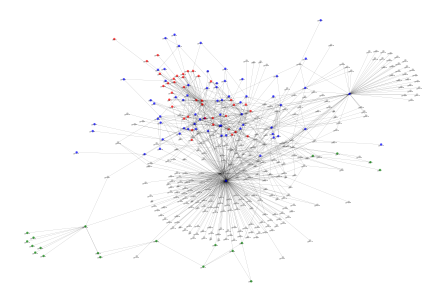

In [14]:

new_ips = ips


new_D = d


dd = dict([(new_ips[i],"[2]"+new_ips[i]) for i in range(len(new_ips)) ] )
# dd = dict([(new_ips[i],"["+ str(int(rs[i]))+"]"+new_ips[i][:2]+str(i)) for i in range(len(new_ips)) if len(new_D[new_ips[i]])> 0])
dg = {}
for sip in new_ips:
    if len(new_D[sip]) > 1:
        dg[dd[sip]] = [dd[ip] for ip in new_D[sip]]
    
    
G = nx.Graph()
for sip in dg:
    for dip in dg[sip]:
        try:

            G.add_edge(sip[:3] + sip[3:], dip[:3] + dip[3:] )
        except:
            print(1)
        
def node2color(ip):
    try:
        return color[cls2[ip[3:]]]#int(cls2[ip[3:]])
#         return int(cls2[ip[3:]])
    except:
        print(ip)
        return "black"
#         return 1

node_color = [node2color(i) for i in G.nodes]

nx.draw(G,node_size= 2.2175,
        alpha= 0.563,
        with_labels= True,
        font_size=2.1, 
        width = 0.1,
        node_color =node_color
        )
plt.savefig("5.jpg", dpi= 2000)

plt.show()
